<a href="https://colab.research.google.com/github/aayushi-goenka/ParalysisEyeMotionDetection/blob/main/VGG19-of.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EXTRACTION OF PRETRAINED NETWORK FROM KERAS


In [3]:
img_height, img_width = (224,224)
batch_size = 32
IMG_SHAPE = (img_height, img_width, 3)#1ST CHANGE
train_data_dir = r"/content/drive/MyDrive/Output_folder/train"
valid_data_dir = r"/content/drive/MyDrive/Output_folder/val"
test_data_dir = r"/content/drive/MyDrive/Output_folder/test"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [4]:

train_datagen = ImageDataGenerator(
                                   shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4)
                                   # rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                 #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                  

Found 3221 images belonging to 4 classes.
Found 399 images belonging to 4 classes.


In [5]:
train_generator.class_indices

{'Closed Eyes': 0,
 'center_eyes_aug': 1,
 'left_eyes_aug': 2,
 'right_eyes_aug': 3}

In [6]:
y_train = train_generator.classes
len(y_train)

3221

In [7]:
nb_validation_samples = 399

In [8]:
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 3 3 3]


(3221,)

In [9]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 404 images belonging to 4 classes.


In [10]:
x,y = test_generator.next()
print(x.shape)
#print(type(x))
#x
print(y.shape)

(1, 224, 224, 3)
(1, 4)


VGG19
ARCHITECTURE

In [11]:
def create_model():

  base_model_3 = VGG19(include_top = False, weights='imagenet',input_shape=IMG_SHAPE)#2ND CHANGE
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# 50 epochs for VGG19 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "C:/Users/user/Desktop/vcg/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 50,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training
    

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.4710 - mse: 0.1754
Epoch 00001: val_accuracy improved from -inf to 0.57031, saving model to C:/Users/user/Desktop/vcg\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 843s 8s/step - loss: 1.3670 - accuracy: 0.4710 - mse: 0.1754 - val_loss: 1.0035 - val_accuracy: 0.5703 - val_mse: 0.1387 - lr: 1.0000e-04
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.9363 - accuracy: 0.5880 - mse: 0.1324
Epoch 00002: val_accuracy improved from 0.57031 to 0.61719, saving model to C:/Users/user/Desktop/vcg\cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 900s 9s/step - loss: 0.9363 - accuracy: 0.5880 - mse: 0.1324 - val_loss: 0.8635 - val_accuracy: 0.6172 - val_mse: 0.1257 - lr: 1.0000e-04
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.7724 - accuracy: 0.6514 - mse: 0.1112
Epoch 00003: val_accuracy did not improve

Epoch 23/50
101/101 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.7907 - mse: 0.0757
Epoch 00023: val_accuracy did not improve from 0.70312
101/101 [==============================] - 1078s 11s/step - loss: 0.5284 - accuracy: 0.7907 - mse: 0.0757 - val_loss: 0.7361 - val_accuracy: 0.6979 - val_mse: 0.1045 - lr: 1.0000e-05
Epoch 24/50
101/101 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.7907 - mse: 0.0723
Epoch 00024: val_accuracy did not improve from 0.70312
101/101 [==============================] - 1083s 11s/step - loss: 0.5076 - accuracy: 0.7907 - mse: 0.0723 - val_loss: 0.7207 - val_accuracy: 0.6771 - val_mse: 0.1053 - lr: 1.0000e-05
Epoch 25/50
101/101 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.7951 - mse: 0.0725
Epoch 00025: val_accuracy did not improve from 0.70312
101/101 [==============================] - 1085s 11s/step - loss: 0.5056 - accuracy: 0.7951 - mse: 0.0725 - val_loss: 0.7238 - val_accur

In [12]:
#model.save('vgg19.h5')
model_1 = tensorflow.keras.models.load_model('/content/drive/MyDrive/vgg19.h5')

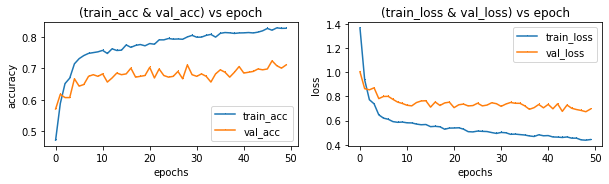

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
f.savefig('C:/Users/user/Desktop/vcg/', bbox_inches='tight', dpi=600)

In [ ]:
#model _1 = tensorflow.keras.models.load_model('ResNet50_100_epochs.h5')

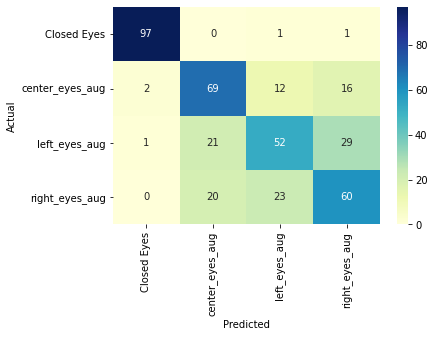

test accuracy: 68.8118811881188


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Closed Eyes', 'center_eyes_aug', 'left_eyes_aug', 'right_eyes_aug']

ROC AUC score: 0.7955046940808639


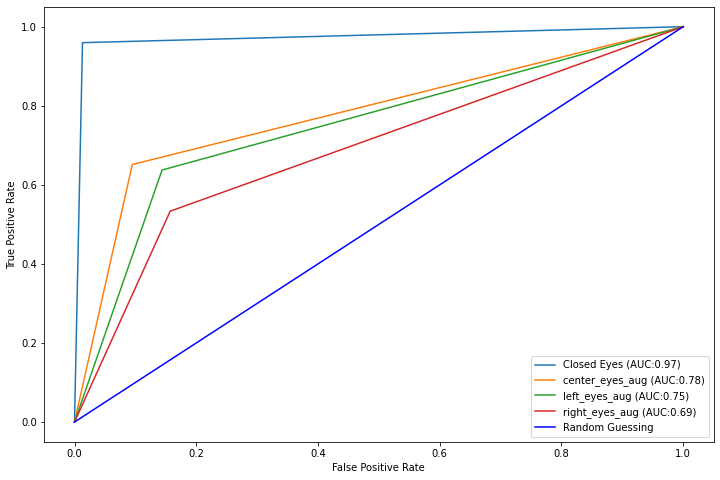

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('vgg19.h5')

In [ ]:
#for image augmentation 

In [ ]:
import os
import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

ModuleNotFoundError: No module named 'cv2'

In [ ]:
#img= cv2.imread(r"/content/drive/MyDrive/Datasets/window_shopping/5142_5141_M_0.png")
img= cv2.imread(r"C:/Users/DHANVANTH/SAMSUNG/z/1.png")
img= cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #we are converting image to BGR because matplotlib displays image BGR format
#if you are using cv2 for displaying image, no need to convert image to BGR

plt.imshow(img)
plt.show()

NameError: name 'cv2' is not defined

In [ ]:

#Lets define functions for each operation
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [ ]:

transformations = {#'rotate anticlockwise': anticlockwise_rotation,
                  #    'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise,
                  'blurring image':blur_image
                 }                #use dictionary to store names of functions 

images_path="C:/Users/DHANVANTH/SAMSUNG/z" #path to original images
augmented_path="C:/Users/DHANVANTH/SAMSUNG/y" # path to store aumented images
images=[] # to store paths of images from folder

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

images_to_generate=70
i=1                        # variable to iterate till images_to_generate

while i<=images_to_generate:    
    image=random.choice(images)
    original_image = io.imread(image)
    transformed_image=None
    print(i)
    n = 0       #variable to iterate till number of transformation to apply
    transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
    while n <= transformation_count:
        key = random.choice(list(transformations)) #randomly choosing method to call
        transformed_image = transformations[key](original_image)
        n = n + 1
        
    new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i+2100)
    transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
    transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
    cv2.imwrite(new_image_path, transformed_image) # save transformed image to path
    i =i+1
#to generate more images, put above 3 statement inside while n<... loop

In [ ]:
#to find the number of images in a file

In [ ]:
APP_FOLDER = 'G:/final_dataset/train/'
#APP_FOLDER = "C:/Users/DHANVANTH/SAMSUNG/y"
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)


Searching in :  G:/final_dataset/train/reflection absent
Total number of files 800


In [13]:
# finetuning
for layer in model_1.layers:
    layer.trainable = True
    print("number of layers in model_1:", len(model_1.layers))
    fine_tune_at = 17
for layer in model_1.layers[:fine_tune_at]:
    layer.trainable = False

opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
model_1.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

model = model_1
model.summary()

number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
number of layers in model_1: 25
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]   

In [14]:
# 30 epochs for VGG model finetuning[finetuning from 17th layer]
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
# checkpoint_path = "C:/Users/Janani/GAIP_NUS/Eye Motion/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.000001)

#csv_logger = CSVLogger('train_log1.csv', separator=',')

# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model_1.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
101/101 [==============================] - ETA: 0s - loss: 0.8569 - accuracy: 0.6138 - mse: 0.1198
Epoch 1: val_accuracy improved from -inf to 0.61458, saving model to /content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 922s 9s/step - loss: 0.8569 - accuracy: 0.6138 - mse: 0.1198 - val_loss: 0.7989 - val_accuracy: 0.6146 - val_mse: 0.1188 - lr: 1.0000e-04
Epoch 2/30
101/101 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.7187 - mse: 0.0922
Epoch 2: val_accuracy improved from 0.61458 to 0.73958, saving model to /content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001
101/101 [==============================] - 51s 503ms/step - loss: 0.6207 - accuracy: 0.7187 - mse: 0.0922 - val_loss: 0.5898 - val_accuracy: 0.7396 - val_mse: 0.0869 - lr: 1.0000e-04
Epoch 3/30
101/101 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.7963 - mse: 0.0698
Epoch 3: val_accuracy improved from 0.73958 to 0.7734

In [15]:
model.save('/content/drive/MyDrive/Colab Notebooks/vgg19_o_finetuning.h5')
model_1 = tensorflow.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/vgg19_o_finetuning.h5')

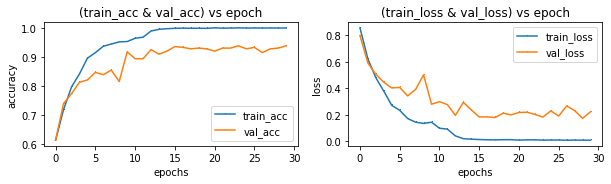

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
#f.savefig('C:/Users/user/Desktop/vcg/', bbox_inches='tight', dpi=600)

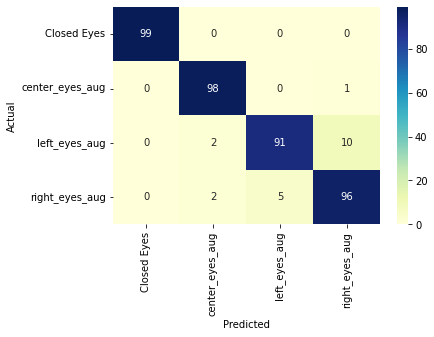

test accuracy: 95.04950495049505


In [16]:
#to plot confusion matrix for 30 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [17]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Closed Eyes', 'center_eyes_aug', 'left_eyes_aug', 'right_eyes_aug']

ROC AUC score: 0.9670793395958959


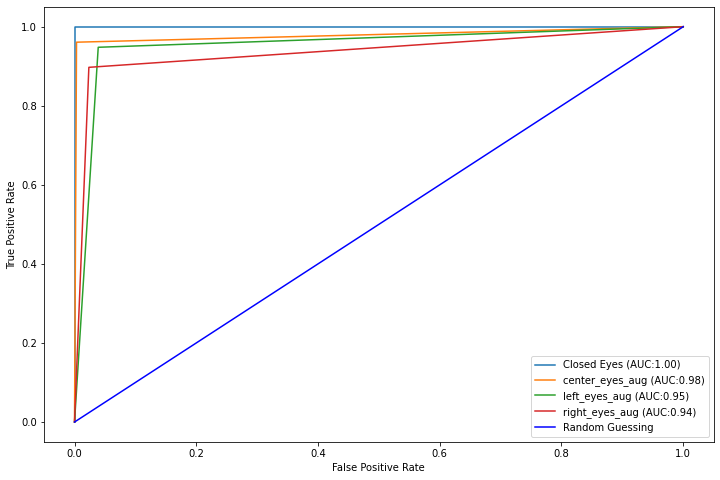

In [18]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()